1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [5]:
import pandas as pd

N = 35000
data = pd.read_csv('data/data_000637.txt', header=0, nrows= N, skiprows = 0)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
34995,1,0,47,3869200515,2127,20
34996,1,0,80,3869200515,2128,19
34997,1,0,48,3869200515,2123,8
34998,1,1,48,3869200515,2285,16


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [9]:
x = max(data["BX_COUNTER"]) + 1   
print("Estimated number of BX in a ORBIT:", x, '\n')

Estimated number of BX in a ORBIT: 3564 



3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [10]:
data['ABSOLUTE_TIME_NS'] = (data['ORBIT_CNT'] * x + data['BX_COUNTER']) * 25 + data['TDC_MEAS']* 25/30
data['ABSOLUTE_TIME_NS'] = data['ABSOLUTE_TIME_NS'] - min(data['ABSOLUTE_TIME_NS'])
data['ABSOLUTE_TIME_SERIES'] = pd.to_datetime(data['ABSOLUTE_TIME_NS'], unit = 'ns')
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME_NS,ABSOLUTE_TIME_SERIES
0,1,0,123,3869200167,2374,26,0.000000e+00,1970-01-01 00:00:00.000000000
1,1,0,124,3869200167,2374,27,8.125000e-01,1970-01-01 00:00:00.000000000
2,1,0,63,3869200167,2553,28,4.476625e+03,1970-01-01 00:00:00.000004476
3,1,0,64,3869200167,2558,19,4.594125e+03,1970-01-01 00:00:00.000004594
4,1,0,64,3869200167,2760,25,9.649125e+03,1970-01-01 00:00:00.000009649
...,...,...,...,...,...,...,...,...
34995,1,0,47,3869200515,2127,20,3.100062e+07,1970-01-01 00:00:00.031000620
34996,1,0,80,3869200515,2128,19,3.100064e+07,1970-01-01 00:00:00.031000644
34997,1,0,48,3869200515,2123,8,3.100051e+07,1970-01-01 00:00:00.031000510
34998,1,1,48,3869200515,2285,16,3.100457e+07,1970-01-01 00:00:00.031004566


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [13]:
import datetime as dt

itime = dt.datetime.now()
print("Begin time:", itime)

# the one-liner command
time =  data['TDC_MEAS'] *(25/30) + data['BX_COUNTER'] * 25 + data['ORBIT_CNT']*x*25

ftime = dt.datetime.now()
print("End time:", ftime)
print("Elapsed time:", (ftime - itime))

Begin time: 2022-12-10 13:45:02.874855
End time: 2022-12-10 13:45:02.876855
Elapsed time: 0:00:00.002000


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [19]:
a = data.groupby(['TDC_CHANNEL']).size().sort_values().iloc[-3:]
print("noisy channels:\n", a, "\n")

noisy channels:
 TDC_CHANNEL
63     1728
64     1768
139    2910
dtype: int64 



6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [20]:
b = data.groupby(['ORBIT_CNT']).size()
print(b)

ORBIT_CNT
3869200167     43
3869200168     85
3869200169    127
3869200170     98
3869200171    109
             ... 
3869200511     67
3869200512    105
3869200513    107
3869200514    125
3869200515     57
Length: 349, dtype: int64


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [30]:
unique_139 = data[data['TDC_CHANNEL']==139]['ORBIT_CNT'].nunique()
print("number of unique orbits of this channel:", unique_139, '\n')

number of unique orbits of this channel: 349 



8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [24]:
s1 = data[data['FPGA']==0].groupby(['TDC_CHANNEL']).size()
s2 = data[data['FPGA']==1].groupby(['TDC_CHANNEL']).size()
print("FPGA = 0 :\n", s1)
print('-----------------------------------------')
print("FPGA = 1 :\n", s2)

FPGA = 0 :
 TDC_CHANNEL
1        29
2        38
3        34
4        46
5        42
       ... 
121     181
122     181
123     497
124     477
139    2034
Length: 118, dtype: int64
-----------------------------------------
FPGA = 1 :
 TDC_CHANNEL
1      767
2      849
3      626
4      696
5      413
      ... 
125     17
126     16
127     36
128     37
139    876
Length: 127, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

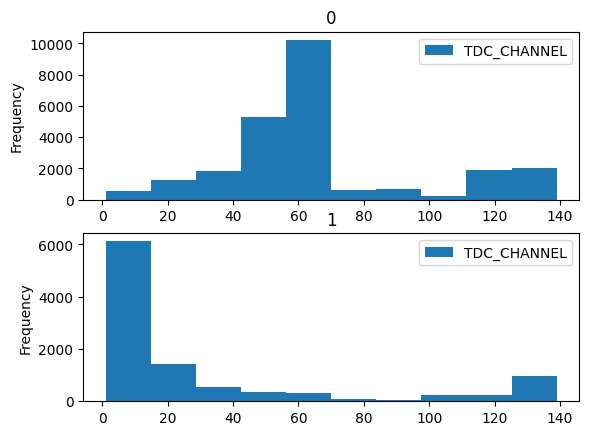

In [25]:
p1 = data.plot.hist(column=["TDC_CHANNEL"], by = "FPGA")